
#Import packages

In [ ]:
# First time installs
# !pip install akida
# !pip install cnn2snn
# !pip install akida-models

# Import packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import librosa.display
import sklearn
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from cnn2snn import check_model_compatibility, quantize, quantize_layer, convert

#Connect to Google Drive

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# SET PATH HERE
%cd /content/drive/My Drive/DL Project/Polly_samples_wav


/content/drive/My Drive/DL Project/Polly_samples_wav


#Reading and pre-proccesing data

In [ ]:
def return_mfcc(path):
  NUM_SEC = 2
  signal, sr = librosa.load(path)

  # truncate to NUM_SEC seconds
  if len(signal) > NUM_SEC*sr:
    signal = signal[0:NUM_SEC*sr]
  elif len(signal) < NUM_SEC*sr:
    signal = np.pad(signal, (0,NUM_SEC*sr-len(signal)))

  mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13,  win_length=750, hop_length=200)

  return mfccs


In [ ]:
# Read all classes using folder names
classes = [d for d in os.listdir('.') if os.path.isdir(d)]

num_samples = 0
for c in classes:
  num_samples += len(os.listdir(c))

print("Number of samples = ", num_samples)

Number of samples =  800


In [ ]:
# X & Y DATA

X = np.empty((num_samples,13,221))
Y = np.empty(num_samples)

sample_no = 0
class_no = 1

for c in classes:
  filelist = os.listdir(c)
  Y[sample_no:sample_no+len(filelist)] = class_no*np.ones(len(filelist))
  class_no += 1

  for f in filelist:
    path = os.path.join(c, f)
    mfcc = return_mfcc(path)

    # insert into matrix X
    X[sample_no] = mfcc
    sample_no += 1

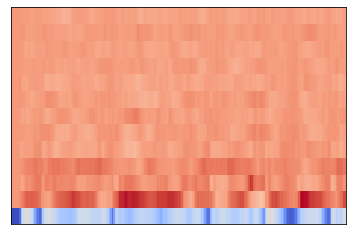

In [ ]:
sr = 22050
librosa.display.specshow(X[199], sr=sr)


#Split data into training and test data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

x_train = X_train.astype('uint8')
x_test = X_test.astype('uint8')

x_train = X_train.reshape(640, 13, 221, 1)
x_test = X_test.reshape(160, 13, 221, 1)


# Set aside raw test data
raw_x_test = X_test
raw_y_test = Y_test


# Rescale data
a = 255
b = 0
input_scaling = (a, b)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = (x_train - b) / a
x_test = (x_test - b) / a

#Modeling

## Scaling MFCC features
> shows how the scaled data used for modeling looks compared to the original mfcc

In [ ]:
X_train_scaled = np.empty((X_train.shape[0], 13, 221))
X_test_scaled = np.empty((X_test.shape[0], 13, 221))

for i in range(X_train.shape[0]):
  X_train_scaled[i] = sklearn.preprocessing.scale(X_train[i], axis=1)

for i in range(X_test.shape[0]):
  X_test_scaled[i] = sklearn.preprocessing.scale(X_test[i], axis=1)


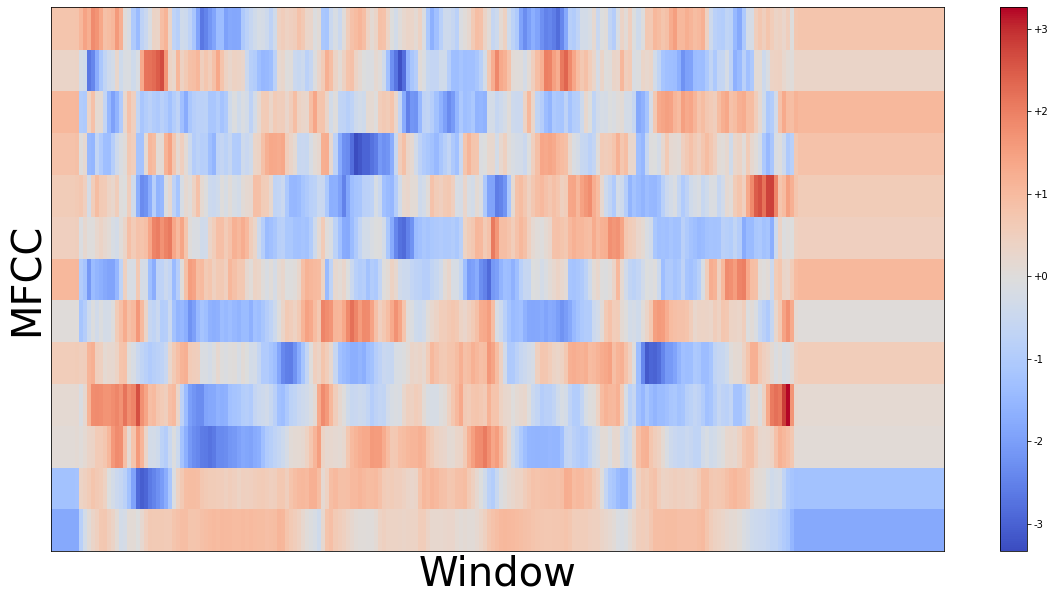

In [ ]:
plt.figure(figsize=(20, 10))
librosa.display.specshow(X_train_scaled[200], 
                         sr=22050)
plt.colorbar(format="%+2.f")

plt.xlabel("Window",fontsize=40)
plt.ylabel("MFCC",fontsize=40)
plt.show()


# Model definition

### Functions to show training loss

In [ ]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))


In [ ]:

def PlotLoss(Loss, model):
  plt.figure(figsize=(20, 10))
  loss = Loss
  plt.plot(loss) 
  plt.title('CrossEntropy Loss for the ' + str(model)) 
  plt.xlabel("Iteration",fontsize=32)
  plt.ylabel("Loss",fontsize=32)


### CNN model

In [ ]:
model_keras = keras.models.Sequential([
    layers.Conv2D(filters=32, kernel_size=3, input_shape=(13, 221, 1)),
    layers.MaxPool2D(),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.SeparableConv2D(filters=32, kernel_size=3, padding='same'),
    layers.MaxPool2D(padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Flatten(),
    layers.Dense(10),
    layers.Softmax()
], 'EarBuds')

model_keras.summary()

Model: "EarBuds"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 11, 219, 32)       320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 109, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 109, 32)        128       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 5, 109, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 109, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 109, 64)        256       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 5, 109, 64)        0   

# Check if model is compatible with Akida

In [ ]:
print("Model compatible for Akida conversion:", check_model_compatibility(model_keras))

Model compatible for Akida conversion: True


# Optimizer

In [ ]:
model_keras.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer='adam',
    metrics=['accuracy'])

CNNhistory = LossHistory()
model_keras.fit(x_train, Y_train, epochs = 50, validation_split = 0.1, callbacks = [CNNhistory])
score = model_keras.evaluate(x_test, Y_test, verbose = 0)
print('Test score:', score[0])

print('Test accuracy:', score[1])

Epoch 1/50
18/18 [==============================] - 3s 118ms/step - loss: 2.1978 - accuracy: 0.2622 - val_loss: 2.3010 - val_accuracy: 0.0938
Epoch 2/50
18/18 [==============================] - 2s 108ms/step - loss: 2.0552 - accuracy: 0.4201 - val_loss: 2.3002 - val_accuracy: 0.0938
Epoch 3/50
18/18 [==============================] - 2s 107ms/step - loss: 1.9750 - accuracy: 0.4861 - val_loss: 2.2988 - val_accuracy: 0.0938
Epoch 4/50
18/18 [==============================] - 2s 109ms/step - loss: 1.9211 - accuracy: 0.5451 - val_loss: 2.2974 - val_accuracy: 0.0938
Epoch 5/50
18/18 [==============================] - 3s 153ms/step - loss: 1.8808 - accuracy: 0.5833 - val_loss: 2.2962 - val_accuracy: 0.0938
Epoch 6/50
18/18 [==============================] - 2s 117ms/step - loss: 1.7771 - accuracy: 0.6962 - val_loss: 2.2946 - val_accuracy: 0.1406
Epoch 7/50
18/18 [==============================] - 2s 108ms/step - loss: 1.7407 - accuracy: 0.7257 - val_loss: 2.2917 - val_accuracy: 0.2344
Epoch 

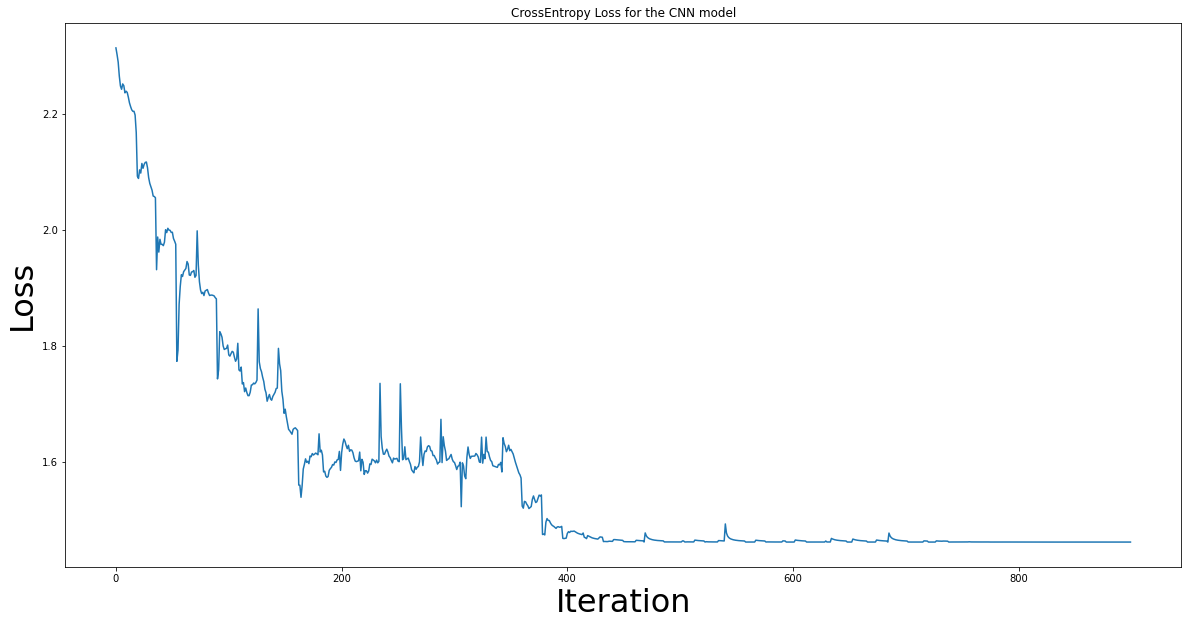

In [ ]:
CNNloss = CNNhistory.losses
PlotLoss(CNNloss, "CNN model")

# Model quantization

In [ ]:
model_quantized = quantize(model_keras,
                           input_weight_quantization = 8,
                           weight_quantization = 4,
                           activ_quantization = 4)
model_quantized.summary()

Model: "EarBuds"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (QuantizedConv2D)   (None, 11, 219, 32)       320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 109, 32)        0         
_________________________________________________________________
re_lu_3 (ActivationDiscreteR (None, 5, 109, 32)        0         
_________________________________________________________________
conv2d_3 (QuantizedConv2D)   (None, 5, 109, 64)        18496     
_________________________________________________________________
re_lu_4 (ActivationDiscreteR (None, 5, 109, 64)        0         
_________________________________________________________________
separable_conv2d_1 (Quantize (None, 5, 109, 32)        2656      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 55, 32)         0   

# Quantized model accuracy

In [ ]:
model_quantized.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer='adam',
    metrics=['accuracy'])

score = model_quantized.evaluate(x_test, Y_test, verbose = 0)
print('Test accuracy after 8-4-4 quantization:', score[1])


Test accuracy after 8-4-4 quantization: 0.9375


# Individual quantizations of layers
 Will save space which is a key factor to keep model small and fast, but can have negative effect on performance.

In [ ]:
model_quantized = quantize_layer(model_quantized, "re_lu_3", bitwidth = 2)
model_quantized = quantize_layer(model_quantized, "re_lu_4", bitwidth = 2)
model_quantized = quantize_layer(model_quantized, "re_lu_5", bitwidth = 2)  
# model_quantized = quantize_layer(model_quantized, "dense", bitwidth = 2)   # Using low bit on dense level decreases performance too much (accuracy = 0.26)
model_quantized = quantize_layer(model_quantized, "dense_1", bitwidth = 4)

model_quantized.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer='adam',
    metrics=['accuracy'])

score = model_quantized.evaluate(x_test, Y_test, verbose = 0)
print('Test accuracy after low bitwidth quantization:', score[1])

Test accuracy after low bitwidth quantization: 0.893750011920929


# Tuning after layer quantification

In [ ]:
SNNhistory = LossHistory()
model_quantized.fit(x_train, Y_train, epochs = 10, validation_split = 0.1, callbacks = [SNNhistory])

score = model_quantized.evaluate(x_test, Y_test, verbose=0)
print('Test accuracy after fine tuning:', score[1])

Epoch 1/10
18/18 [==============================] - 3s 112ms/step - loss: 1.4692 - accuracy: 0.9948 - val_loss: 1.5770 - val_accuracy: 0.8906
Epoch 2/10
18/18 [==============================] - 2s 112ms/step - loss: 1.4642 - accuracy: 0.9983 - val_loss: 1.5692 - val_accuracy: 0.8906
Epoch 3/10
18/18 [==============================] - 2s 111ms/step - loss: 1.4622 - accuracy: 1.0000 - val_loss: 1.5478 - val_accuracy: 0.9375
Epoch 4/10
18/18 [==============================] - 2s 112ms/step - loss: 1.4621 - accuracy: 1.0000 - val_loss: 1.5372 - val_accuracy: 0.9375
Epoch 5/10
18/18 [==============================] - 2s 111ms/step - loss: 1.4612 - accuracy: 1.0000 - val_loss: 1.5366 - val_accuracy: 0.9219
Epoch 6/10
18/18 [==============================] - 2s 110ms/step - loss: 1.4612 - accuracy: 1.0000 - val_loss: 1.5378 - val_accuracy: 0.9219
Epoch 7/10
18/18 [==============================] - 2s 109ms/step - loss: 1.4612 - accuracy: 1.0000 - val_loss: 1.5329 - val_accuracy: 0.9219
Epoch 

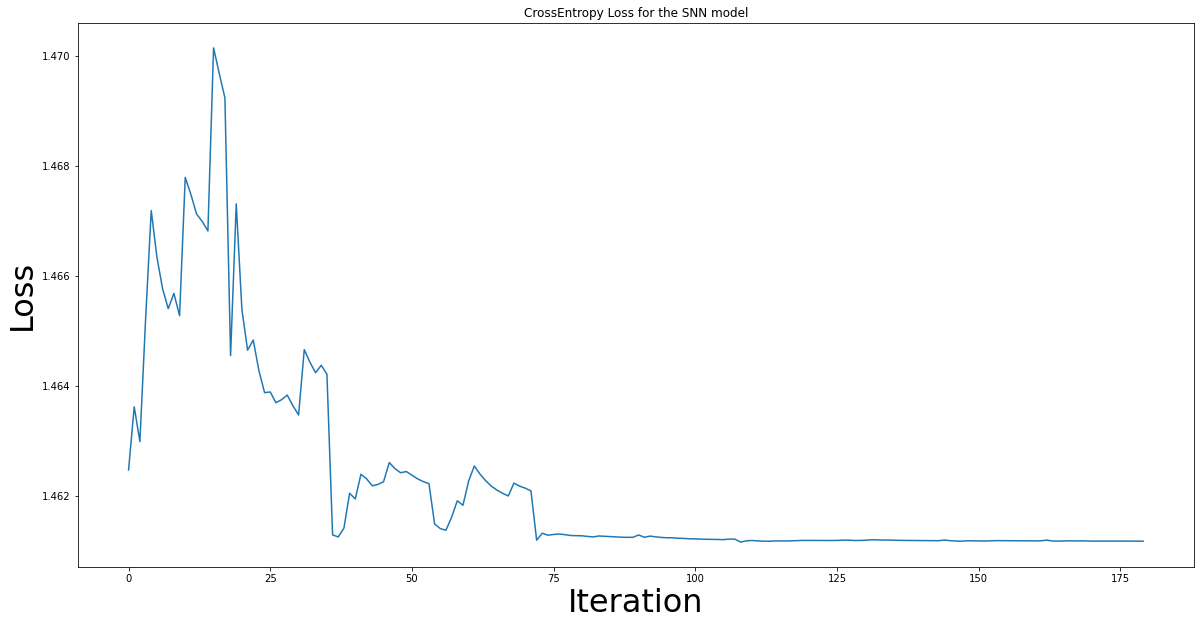

In [ ]:
PlotLoss(SNNhistory.losses, "SNN model")

# Convert quantized model to Akida format

In [ ]:
model_akida = convert(model_quantized, input_scaling = input_scaling)
model_akida.summary()

                 Model Summary                 
_______________________________________________
Input shape   Output shape  Sequences  Layers
[13, 221, 1]  [1, 1, 10]    1          4     
_______________________________________________

                  SW/conv2d-dense (Software)                  
______________________________________________________________
Layer (type)                  Output shape  Kernel shape    
conv2d (InputConv.)           [109, 5, 32]  (3, 3, 1, 32)   
______________________________________________________________
conv2d_1 (Conv.)              [109, 5, 64]  (3, 3, 32, 64)  
______________________________________________________________
separable_conv2d (Sep.Conv.)  [55, 3, 32]   (3, 3, 64, 1)   
______________________________________________________________
                                            (1, 1, 64, 32)  
______________________________________________________________
dense (Fully.)                [1, 1, 10]    (1, 1, 5280, 10)
___________________